# Data 512 Final Project: Measuring political polarization in United States Congressional roll-call votes over the last 2003-2020

Has political polarization spread into the U.S. legislative process? News articles have suggsted that increaseed political polarization could have far-reaching consequences on people's everyday lives on everything from their personal interactions to their physical health ([source](https://greatergood.berkeley.edu/article/item/what_is_the_true_cost_of_polarization_in_america)). While polarization's impact on the legislative process has been cited in articles, such as the [ping-poing effect on energy regulation](https://www.spglobal.com/platts/en/market-insights/latest-news/coal/102320-us-elections-political-polarization-creating-regulatory-ping-pong-effect-for-us-energy), few articles have cited a measurement to evaluate the polarization of the legislative process <i>directly</i>. To address this, this notebook attempts to measure political polarization of both chambers of Congress through the results of their roll-call votes.

# Background: Why should we care about roll-call votes versus other methodologies?

Roll call votes directly decide whether a bill passes a chamber of Congress; in other words: a bill cannot become a law without passing these votes. This, as previously mentioned, is a very direct indicator of polarization. A few Google searches have not found substantial and accessible analyses of roll-call vote data to measure political polarization. Many news articles represent congress people through ideological scores e.g., [NYT](https://www.nytimes.com/2014/06/12/upshot/polarization-is-dividing-american-society-not-just-politics.html), [Pew](https://www.pewresearch.org/fact-tank/2014/06/12/polarized-politics-in-congress-began-in-the-1970s-and-has-been-getting-worse-ever-since/)) or [polling data](https://fivethirtyeight.com/features/how-hatred-negative-partisanship-came-to-dominate-american-politics/), or [individual Congressional members ideology](https://www.pewresearch.org/fact-tank/2013/07/17/partisan-polarization-in-congress-and-among-public-is-greater-than-ever/) as measured by their voting stances ([1](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#Political_polarization), [2](https://scholar.harvard.edu/files/rogowski/files/npat-paper-july2019.pdf)). 

## Advantages of this methodology
In comparison to these contemporary methods, the method of measuring here may offer the following advantages:

   1. Simpler methodology: rather than the more complex algorithms behind ideological scores such as NOMINATE.
   2. The underlying dataset is publicly accessible -- whereas survey data may not be.
   2. The roll-call vote is a direct outcome of legislative intent compared to ideological score or survey data.
   
## Disadvantages of this methodology
In comparison to these contemporary methods, the method of measuring here may offer the following disadvantages:


   1. Capturing heterogenuous behavior by topic. For example, NOMINATE scores offer a more granular view of the ideological score of each member of Congress along multiple dimensions analyses may care about (e.g., economic policy, culture and lifestyle). [Here's an example](https://voteview.com/rollcall/RS1150179) of such a breakdown for DW NOMINATE along these axes.
   2. Less robust at analyzing differences in individual's ideology.
   
# Research questions
Let us define the difference in votes as follows:

$$ \text{difference in votes} = \left| \text{Percentage of Democratic vote in favor} - \text{Percentage of Republican vote in favor} \right| $$

This metric serves as the primary measure of polarization in a roll-call vote.

The research questions this notebook attempts to answer are:

  1. Has average polarization in Congress increased year-over-year from 2003-2020?
  2. Are the most and least polarized votes more extreme year-over-year from 2003-2020?
  3. Has the pass rate of roll-call votes changed from 2003-2020?

# Dataset
We will use the open-sourced [congress GitHub](https://github.com/unitedstates/congress) set of scrapers to download Congressional roll-call vote data from 2000-2020. More specifically, we'll utilize the [votes data](https://github.com/unitedstates/congress/wiki/votes) which contains data on Congress roll-call votes. For more details see "Appendix: How to obtain the starting data".

From the project:

> This project collects data on roll call votes, which are the sorts of votes in which the individual positions of legislators is recorded. Other sorts of votes such as unanimous consent requests and voice votes are not collected here.
> 
> Congress publishes roll call vote data in XML starting in 1990 (101st Congress, 2nd session) for the House and 1989 (101st Congress, 1st Session) for the Senate. Senate votes are numbered uniquely by session. Sessions roughly follow calendar years, and there are two sessions per Congress. House vote numbering continues consecutively throughout the Congress.

NOTE: despite what the source says, there were errors getting data before 2003, as such we truncated the dataset for this analysis to just 2003-2020.

The dataset schema is similar to what follows (maybe updated depending on whether or not I pull in additional data from the scraper):

| Name | Description | Example Value |
| ----- | ----------------------| ------ |
| chamber | Either "h" for House or "s" for Senate | "h" |
| congress | Number of the Congress which carried out this vote | 112 |
| date | The date the roll-call vote happened | "2013-07-18T22:40:39-04:00" |
| number | The number of the vote | 202 |
| session | The year that Congress carried out this vote | 2013 |
| source_url | The source url for the data | "http://clerk.house.gov/evs/2013/roll202.xml"
| updated_at | The date that the data was updated at | "2013-07-18T22:40:39-04:00" |
| vote_id | The vote id of the roll-call vote | "h202-113.2013" |
| category | The type of roll-call vote | "amendment" |
| question | The question that the roll-call vote is on | "On Agreeing to the Amendment: Amendment 24 to H R 2217" |
| type | The type of vote this is | "On the Amendment" |
| requires | The fraction of the vote required to pass | "1/2" |
| result | The result of the roll-call vote | "failed" |
| result_text | The result of the vote (this is just a duplicate field according to the documentation) | "Failed" |
| display_name | Congress person's display name | "John Jay" |
| party | "D" for Democrat, "R" for Republican | "R" |
| state | Two-letter state abbreviation of the state that the congressperson represents | "NC"

# Methodology
Due to the limited size of the summarized annual dataset (17 years) we rely on exploratory data analysis through visualizations and tables to determine the trends in polarization through the difference in votes.

This notebook contains all relevant code required to reproduce this methodology

# Analysis
## Preparing the data and making sure years are comparable
### Loading the data
The data that you've downloaded (either from the supporting GitHub repo) or directly from the source (see "Appendix: How to obtain the starting data"), will need to be loaded from JSON files into a dataframe to make the analysis easier.

The following code does precisely that, first defining a function *read_to_df* which transforms the JSON file into a row of a dataframe. This function flattens the structure of the JSON keys to make the dataframe easier to work with.

Then it loads all JSON files from the data directory and uses *read_to_df* to concatenate together a dataframe which will be used for the analysis.

In [1]:
import json
import pandas as pd

def add_flattened_subkey(json, root_key, key):
    '''
        Adds the json[root_key][key] into the JSON object with the key "{root_key}_{key}"
        :param json: the JSON object which represents the source JSON file.
        :param root_key: the JSON key to flatten and add back into the JSON object.
        :param rkey: the JSON key under the root_key to add back into the JSON object.
    '''
    if key in json[root_key].keys():
        json[f"{root_key}_{key}"] = json[root_key][key]

def flatten_key(json, key):
    '''
        Removes the :param key:, if it exists, and adds the flattened version to it.
        :param json: the JSON object which represents the source JSON file.
        :param key: the JSON key to flatten and add back into the JSON object.
    '''
    if key in json.keys():
        for k,v in json[key].items():
            add_flattened_subkey(json, key, k)
        del json[key]


def read_to_df(file_name, debug=False):
    '''
        :param file_name: the name of the JSON file to read into a dataframe format
        :param debug: Default value is False. True if to run the function in debug mode and output more verbose information. False, otherwise.
        :returns: a dataframe representation of the JSON file to be used for analysis.
    '''
    parties=["D","R","I"]
    with open(file_name, "r") as file:
        f = json.load(file)
        if f["category"] == "leadership":
            return pd.DataFrame()
        res = {}
        # there are a few fields which are specialized to the senate.
        is_senate = f["chamber"] == "s"
        # debug mode outputs the JSON, useful for debugging the parsing mechanism.
        if debug:
            display(f)
        vp_tie_breaker=False
        # bills, amendments, nominations, and treaties all have special data that needs to be flattened. Otherwise, the data won't be structured when we transform it into a dataframe!
        flatten_key(f, "bill")
        flatten_key(f, "amendment")
        flatten_key(f, "treaty")
        flatten_key(f, "nomination")
        # keep only aggregate vote counts by party identification
        for k,v in f["votes"].items():
            try:
                if len(v)==0:
                    # Deal with cases where there are no votes in a category.
                    counts = {"Count":{}}
                else:
                    if is_senate and "VP" in v:
                        vp_tie_breaker=True
                        v.remove("VP") # remove VP if it exists -- we're interested in congressional votes.
                    counts = pd.DataFrame(v).groupby("party")["id"].agg(Count="count").to_dict()
                # Aggregate vote count by party identification
                for party in parties:
                    vote_dict_key = f"vote_{k}_{party}"
                    if party not in counts["Count"].keys():
                        f[vote_dict_key]=0
                    else:
                        f[vote_dict_key]=counts["Count"][party]
            except:
                print(f"Exception in : {k}")
                raise
        del f["votes"]
        f["vp_tie_breaker"]="Yes" if vp_tie_breaker else "No"
        # Keep file name for debugging
        f["file_name"] = file_name
        return pd.DataFrame(f, index=[0])

# an example of how to use this function in debug mode for a source JSON file.
# read_to_df("data\\data\\101\\votes\\1989\\s100\\data.json", debug=True)

Now identify all JSON files containing the roll call voting data.

In [2]:
import glob

#JSON data path with regex
data_path = "data\\data\\**\\**\\**\\**\\*.json"

files_to_read = glob.glob(data_path)

We process each JSON file into a dataframe, and then concatenate them together. The below code block also outputs the percentage completion every ~20% it completes.

In [3]:
import math
def process_df(file_name, i, total_length):
    '''
        :param file_name: the name of the file to convert into a dataframe
        :param i: the iteration number that this file represents
        :param total_length: the total number of files to process
        :throws: can throw an exception if there was an error parsing a file
        :returns: a dataframe representing the JSON file provided to the function
    '''
    one_fifth = int(math.ceil(0.2 * total_length))
    if i % one_fifth == 0:
        print(f"Loading data... {i * 100.0 / total_length}% done")
    try:
        return read_to_df(file_name)
    except Exception as e:
        print(f"file: {file_name}. {str(e)}")
        raise e

from os import path
if not path.exists("data/full.csv"):
    list_of_dfs = [process_df(files_to_read[i], i, len(files_to_read)) for i in range(len(files_to_read))]
    df = pd.concat(list_of_dfs, ignore_index=True, sort=False)
    print("100% done!")
    print("Successfully created dataframe from JSON files.")
else:
    print("data/full.csv already exists -- reading data from the cached data.")
    df = pd.read_csv("data/full.csv")

data/full.csv already exists -- reading data from the cached data.


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Next, we structure some of the date data that we care about.

  * Convert "date" column to a datetime
  * Create "year" column since we will be using this often in our analysis
  * Add "full_chamber_name" that way we display "senate" or "house" rather than just "s" or "h". This will make the charts we make later easier to read.

In [4]:
import numpy as np
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].apply(lambda x: x.year)


In [5]:
df.loc[df["chamber"]=="s","full_chamber_name"] = "senate"
df.loc[df["chamber"]=="h","full_chamber_name"] = "house"

Cache the results to a CSV for later use that way you do not need to repeat long-running steps.

In [6]:
if not path.exists("data/full.csv"):
    df.to_csv("data/full.csv", index=False)
    print("Wrote to data/full.csv")

Next, we only take the years 2003 and after, since as we previously mentioned the scraper had issues collecting data prior to 2003.

In [7]:
df = df[df["year"] >= 2003]

### Add vote totals
The below code block adds the percent and total vote totals for analysis. We note that we disclude independents from the totals (there are relatively few in the dataset anyway). Moreover, we consider those who abstain from the vote as voting in opposition for simplicity. However, [abstaning may also represent many other political stances](https://en.wikipedia.org/wiki/Abstention).

We add the following metrics for each party ("R" for Republican, "D" for Democrat, "I" for Independent), templatized values are in curly braces (e.g., "{this/that}"):

| column name | description |
| ---------------------------------------| ----------------------------------|
| pct {for/against} {R/D/I} votes | The percentage of the respective party which voted for/against in the roll call vote |
| total {R/D/I} votes | The total number of votes the respective party cast for a bill either for or against |
| total {for/against} {R/D/I} votes | The total (i.e.: count) of votes of the respective party which voted for/against in the roll call vote |

The voting positions are mapped to either "for" or "against" as follows:

| For or Against | voting position |
| -------------- | --------------------------------------- |
| against | "Present", "Not Voting", "Nay", "No" |
| for | "Yea", "Aye" |

In [8]:
NO_VOTE_PREFIXES = [
    "vote_Present",\
    "vote_Not Voting",\
    "vote_Nay",\
    "vote_No",\
]

YES_VOTE_PREFIXES = [
    "vote_Yea",\
    "vote_Aye"
]

# List of parties we care about.
PARTIES = ["R", "D", "I"]

def pct_votes(party, for_or_against):
    '''
        gets the name of the pct_votes column for the provided parameters.
        :param party: the name of the party to get the column name for.
        :param for_or_against: either "for" or "against".
        :returns: the name of the pct votes column for the given party and for_or_against_value
    '''
    possible_arguments = {"for", "against"}
    if for_or_against not in possible_arguments:
        raise Exception(f"Must be one of {possible_arguments}")
    return f"pct {for_or_against} {party} votes"

def total_votes(party, for_or_against_or_total):
    '''
        gets the name of the total_votes column for the provided parameters.
        :param party: the name of the party to get the column name for.
        :param for_or_against: either "for" or "against" or "total".
        :returns: the name of the total votes column for the given party and for_or_against_value
    '''
    possible_arguments = {"for", "against", "total"}
    if for_or_against_or_total not in possible_arguments:
        raise Exception(f"Must be one of {possible_arguments}")
    if for_or_against_or_total == "total":             
        return f"total {party} votes"
    else:
        return f"total {for_or_against_or_total} {party} votes"

def add_vote_totals_by_party(df):
    for party in PARTIES:
        no_vote_cols = [f"{x}_{party}" for x in NO_VOTE_PREFIXES]
        yes_vote_cols = [f"{x}_{party}" for x in YES_VOTE_PREFIXES]
        no_vote_cols_id = []
        yes_vote_cols_id = []
        df[total_votes(party, "against")] = df.loc[:, np.concatenate((no_vote_cols, no_vote_cols_id))].sum(axis=1)
        df[total_votes(party, "for")] = df.loc[:, np.concatenate((yes_vote_cols, yes_vote_cols_id))].sum(axis=1)
        df[total_votes(party, "total")] = df[total_votes(party, "for")] + df[total_votes(party, "against")]
        df[pct_votes(party, "against")] = df[total_votes(party, "against")] * 100.0 / df[total_votes(party, "total")] 
        df[pct_votes(party, "for")] = df[total_votes(party, "for")] * 100.0 / df[total_votes(party, "total")] 



In [9]:
add_vote_totals_by_party(df)
df.head(5)

,category,chamber,congress,date,number,question,requires,result,result_text,session,...,total against D votes,total for D votes,total D votes,pct against D votes,pct for D votes,total against I votes,total for I votes,total I votes,pct against I votes,pct for I votes
4748,quorum,h,108,2003-01-07 12:30:00-05:00,1,Call By States,QUORUM,Passed,Passed,2003,...,205.0,0.0,205.0,100.000000,0.000000,1.0,0.0,1.0,100.0,0.0
4749,unknown,h,108,2003-01-08 20:45:00-05:00,10,Table the appeal of the ruling of the Chair: H...,1/2,Passed,Passed,2003,...,204.0,0.0,204.0,100.000000,0.000000,1.0,0.0,1.0,100.0,0.0
4750,amendment,h,108,2003-04-02 14:28:00-05:00,100,On Agreeing to the Amendment: Amendment 1 to H...,1/2,Failed,Failed,2003,...,20.0,185.0,205.0,9.756098,90.243902,0.0,1.0,1.0,0.0,100.0
4751,recommit,h,108,2003-04-02 14:54:00-05:00,101,On Motion to Recommit with Instructions: H R 7...,1/2,Failed,Failed,2003,...,3.0,202.0,205.0,1.463415,98.536585,0.0,1.0,1.0,0.0,100.0
4752,passage,h,108,2003-04-02 15:01:00-05:00,102,On Passage: H R 743 Social Security Protection...,1/2,Passed,Passed,2003,...,29.0,176.0,205.0,14.146341,85.853659,0.0,1.0,1.0,0.0,100.0


### How are the votes distributed through the years?

We want to make sure that there are sufficient votes by year, that way our estimate for the difference in votes is meaningful.

For example, if there are very few votes in any given year the mean difference in votes may be a high variance estimate of the true mean difference in votes. 

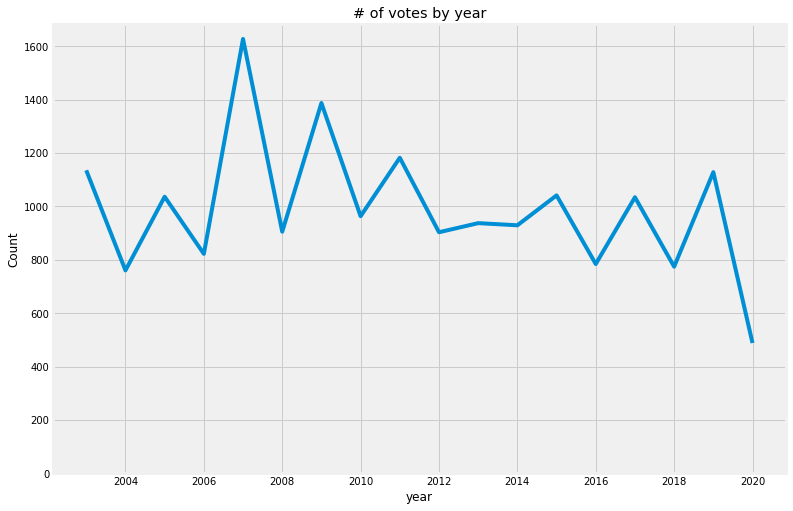

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)

tmp=df.groupby("year")["year"].agg(Count="count").reset_index()
sns.lineplot(x="year", y="Count", data=tmp, ax=ax)
plt.gca().set_ylim(bottom=0)
plt.title("# of votes by year")
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


We note that despite almost being a full year of roll call votes for 2020 (it is around December 10th, 2020 at the time of this report), the number of roll call votes in 2020 is at an all time low compared to the last 17 years. This aligns with [articles which report that Congressional productivity has dropped substantially in 2020](https://www.axios.com/congress-legislation-covid-19-2020-28a81b79-8cfc-4fc6-8fa6-e1758dd5f81f.html).

The vote passage rate also appears periodic, increasing during odd years and decreasing during even years. This could be tied to the even years being midterm elections -- and sometimes presidential elections (e.g., 2004 or 2008).

On the other hand, 2007 had the maximum number of roll call votes from 2003-2020, [which aligns closely with the Great Recession](https://en.wikipedia.org/wiki/Great_Recession).

## Question 1: Has average polarization in Congress increased year-over-year from 2003-2020?

First, we display a graph representing the difference in votes in both chambers of congress. The dotted lines represent presidential election years.

'Table: Difference in votes by year'

Text(0.5, 1.0, 'Difference in votes by Chamber of Congress')

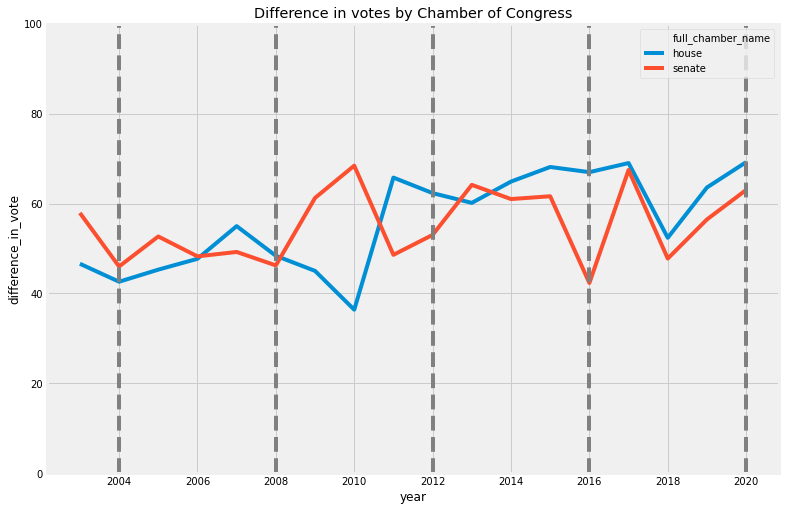

In [11]:
diff_col = "difference_in_vote"
df[diff_col] = np.abs(df[pct_votes("D", "for")] - df[pct_votes("R", "for")])
fig=plt.figure()
fig.set_size_inches(11.7, 8.27)

ax = fig.gca()
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
tmp = df.groupby(["year", "full_chamber_name"])[diff_col].mean().reset_index()
display("Table: Difference in votes by year")
sns.lineplot(x="year", y="difference_in_vote", hue=tmp["full_chamber_name"], data=tmp)
plt.ylim((0,100))
for i in range(2004, 2024, 4):
    plt.axvline(x=i,c="gray", linestyle="--")
plt.title("Difference in votes by Chamber of Congress")

Unforunately, there is not enough history to draw strong conclusions on the trend. The variance in the difference of votes appears to increase after 2008. While the Senate's increase in difference in vote appears relatively moderate (~58% in 2003 to 63% in 2020), the House appears to increase year over year, going from roughly ~46% in 2003 to ~69% in 2020. 

However, as the line chart shows, the difference in vote is unstable, even after 2008, the chambers of Congress saw dips in the difference in votes. Notably, the Senate saw a substantial decrease in 2016, maybe this is due to a larger Republican majoirty in the Senate and the election of a Republican President.

### Is the variance in polarization increasing year over year?
Let us also take a look at the absolute difference year over year in the difference in votes through the bar chart from the next code block.

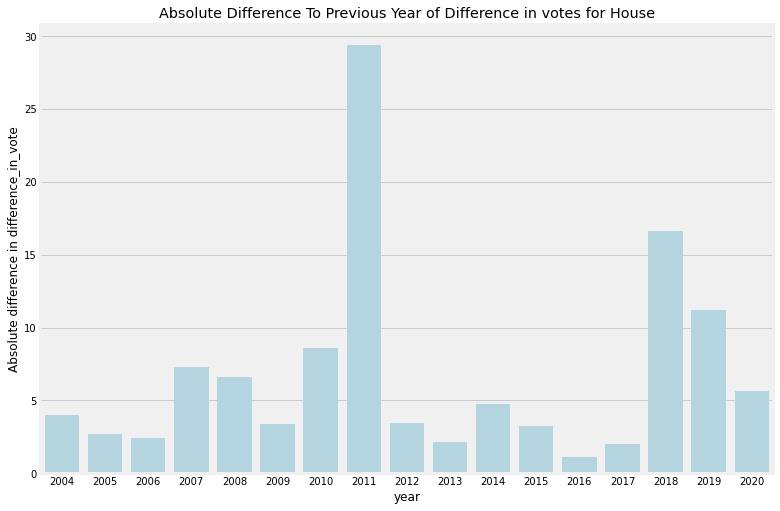

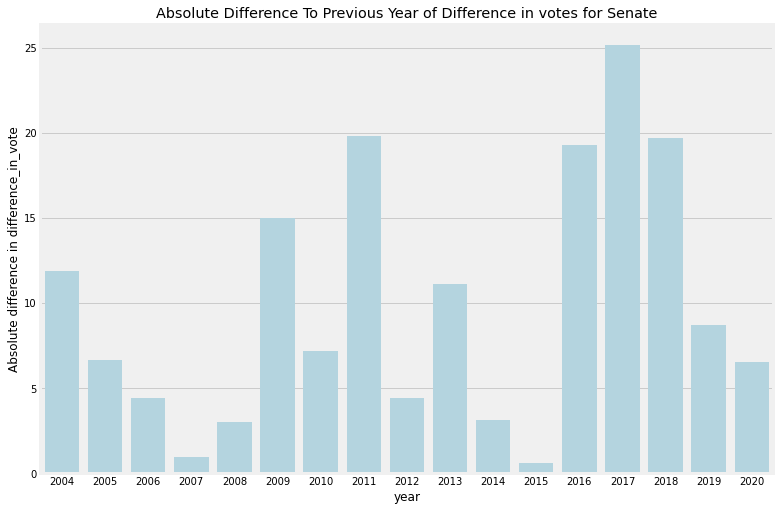

In [12]:
diff_col = "difference_in_vote"
df[diff_col] = np.abs(df[pct_votes("D", "for")] - df[pct_votes("R", "for")])
tmp = df.groupby(["year", "full_chamber_name"])[diff_col].mean().reset_index().sort_values(by=["full_chamber_name", "full_chamber_name"])
for chamber in ["house", "senate"]:
    tmp.loc[tmp["full_chamber_name"]==chamber, "previous difference_in_vote"] = tmp.loc[tmp["full_chamber_name"]==chamber,"difference_in_vote"].shift(1)
tmp["Absolute difference in difference_in_vote"] = np.abs(tmp["difference_in_vote"] - tmp["previous difference_in_vote"])
for chamber in ["House", "Senate"]:
    fig=plt.figure()
    fig.set_size_inches(11.7, 8.27)
    ax = fig.gca()
    from matplotlib.ticker import MaxNLocator
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    tmp_to_display=tmp.loc[(tmp["full_chamber_name"]==chamber.lower()) & (tmp["year"] > 2003),]
    sns.barplot(x="year", y="Absolute difference in difference_in_vote", color="lightblue", data=tmp_to_display)
    plt.title(f"Absolute Difference To Previous Year of Difference in votes for {chamber}")
    plt.show()

From the charts it appears that:
  * House: There is a slight increase in variance in polarization in more recent times than to 17 years ago.
  * Senate: there appears to be some level of cyclicality to the variance in polarization, and potentially a smaller increase in variation in polarization in more recent times than the House.

Of particular interest, it appears that 2011 saw the biggest difference in polarization with a +30 percentage point increase in the difference in votes metric. This is an outlier to all other years. The next closest year in difference is 2018 (+17 percentage point increase). Both of these changes came on the backs of significant shifts in power dynamics: the 2010 elections saw Republicans make significant gains in the [Senate (7 seats), and the House (68 seats, the most since 1968)](https://en.wikipedia.org/wiki/2010_United_States_elections) under a Democratic President; the 2018 elections [saw Democrats take control of the House](https://en.wikipedia.org/wiki/2018_United_States_elections) from Republicans under a Republican President.

## Q2: Are the most and least polarized votes more extreme year-over-year from 2003-2020?

So the results from Q1 suggest that there is a case to be made for increased polarization on average in Congress in the last 17 years based on the difference in votes metric. Are the extremely polarized bills becoming more polarized during that same time period?

One way of looking at this could be the trend in the 25th and 75th percentiles of the difference in vote year over year. We do this in the code block below.

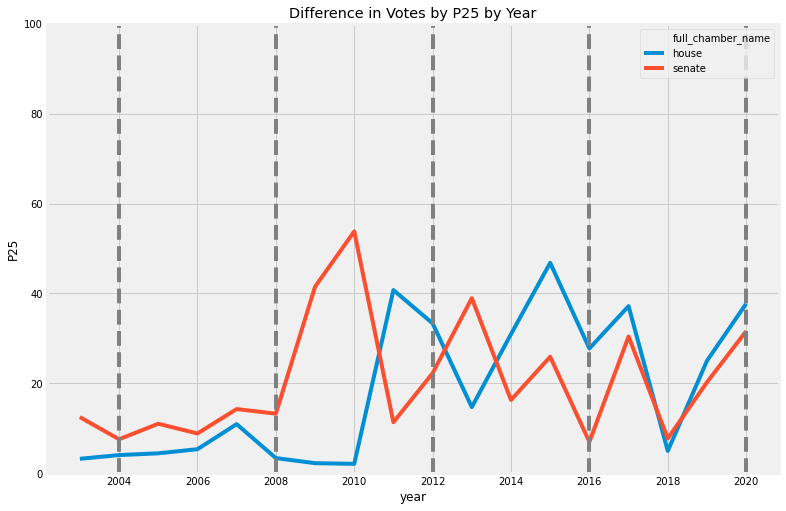

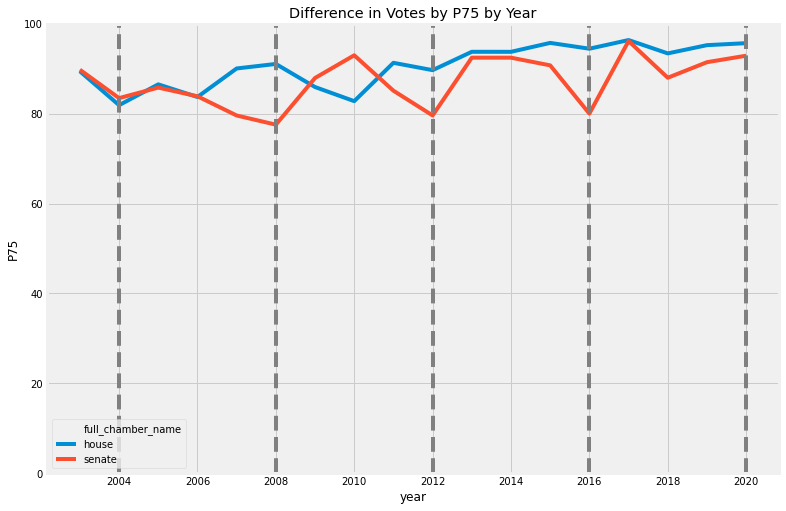

In [13]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.median()

def q3(x):
    return x.quantile(0.75)


fig=plt.figure()
fig.set_size_inches(11.7, 8.27)


tmp=df.groupby(["year", "full_chamber_name"])[diff_col].agg(Avg="mean", P25=q1, P50=q2, P75=q3).reset_index()

ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

sns.lineplot(x="year", y="P25", hue=tmp["full_chamber_name"], data=tmp)
plt.ylim((0,100))
for i in range(2004, 2024, 4):
    plt.axvline(x=i,c="gray", linestyle="--")
plt.title("Difference in Votes by P25 by Year")
plt.show()

fig=plt.figure()
fig.set_size_inches(11.7, 8.27)

ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

sns.lineplot(x="year", y="P75", hue=tmp["full_chamber_name"], data=tmp)
plt.ylim((0,100))
for i in range(2004, 2024, 4):
    plt.axvline(x=i,c="gray", linestyle="--")
plt.title("Difference in Votes by P75 by Year")
plt.show()


Similarly to the chart drawn in Q1, we see that the P25 has increased and become variable after 2008, suggesting that there are fewer roll-call votes which are not polarized. Meanwhile, the P75 saw relatively modest increases in polarization over the same time period.

The graphs of polarization suggest that the most polarized debates have seen small increases in polarization but the least polarized debates have seen a much more pronounced increase in polarization.

## Q3: Has the pass rate of roll-call votes changed from 2003-2020?
Now that we have shown that Congress may have increased in polarization according to the difference in votes from 2003 to 2020, we wonder whether this increase in polarization has resulted in a change in the pass rate of roll-call votes from 2003-2020.

In order to do this however, we must first define what it means to pass a bill. A bill is defined as having "Failed" if its "result" in the Congress dataset contains any of the following strings:
  1. "Not"
  2. "Rejected"
  3. "Failed"
  4. "Veto Sustained"
  5. "Defeated"

We see that that means the following results will be considered as "Failed" in this analysis.

In [14]:
NOT_PASSED = [
    'Not',
    'Rejected',
    'Failed',
    'Veto Sustained',
    'Defeated'
]

def get_passed_or_failed(result):
    if any(state in result for state in NOT_PASSED):
        return "Failed"
    return "Passed"

df["final_result"] = df["result"].apply(get_passed_or_failed)

df.loc[df["final_result"]== "Failed", "result"].unique()

array(['Failed', 'Amendment Rejected', 'Motion Rejected',
       'Cloture Motion Rejected', 'Motion to Table Failed',
       'Cloture on the Motion to Proceed Rejected',
       'Point of Order Not Sustained', 'Bill Defeated',
       'Objection Not Sustained', 'Joint Resolution Defeated',
       'Amendment Not Germane', 'Motion to Recommit Rejected',
       'Motion to Proceed Rejected', 'Point of Order Not Well Taken',
       'Decision of Chair Not Sustained',
       'Concurrent Resolution Rejected', 'Resolution Rejected',
       'Resolution of Ratification Rejected',
       'Motion to Adjourn Rejected', 'Motion to Refer Rejected',
       'Veto Sustained', 'Motion to Postpone Rejected',
       'Motion to Discharge Rejected', 'Not Guilty'], dtype=object)

Here is the list of results which we consider as "Passed" in this analysis:

In [15]:
df.loc[df["final_result"] == "Passed", "result"].unique()

array(['Passed', 'Agreed to', 'Motion to Adjourn Agreed to',
       'Amendment Agreed to', 'Concurrent Resolution Agreed to',
       'Bill Passed', 'Nomination Confirmed', 'Motion to Table Agreed to',
       'Resolution Agreed to', 'Conference Report Agreed to',
       'Resolution of Ratification Agreed to', 'Motion Agreed to',
       'Joint Resolution Passed', 'Motion for Attendance Agreed to',
       'Motion to Proceed Agreed to', 'Cloture Motion Agreed to',
       'Cloture on the Motion to Proceed Agreed to',
       'Motion to Reconsider Agreed to', 'Amendment Germane',
       'Decision of Chair Sustained', 'Veto Overridden',
       'Motion to Table Motion to Recommit Agreed to', 'Guilty',
       'Motion to Discharge Agreed to', 'Point of Order Well Taken'],
      dtype=object)

In [16]:
df[df["result"]=="Guilty"]

,category,chamber,congress,date,number,question,requires,result,result_text,session,...,total D votes,pct against D votes,pct for D votes,total against I votes,total for I votes,total I votes,pct against I votes,pct for I votes,difference_in_vote,final_result
13264,conviction,s,111,2010-12-08 10:13:00-05:00,261,Guilty or Not Guilty H.Res. 1031,2/3,Guilty,"Guilty (96-0, 2/3 majority required)",2010,...,2.0,100.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,Passed
13265,conviction,s,111,2010-12-08 10:26:00-05:00,262,Guilty or Not Guilty H.Res. 1031,2/3,Guilty,"Guilty (69-27, 2/3 majority required)",2010,...,2.0,100.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,Passed
13266,conviction,s,111,2010-12-08 10:40:00-05:00,263,Guilty or Not Guilty H.Res. 1031,2/3,Guilty,"Guilty (88-8, 2/3 majority required)",2010,...,2.0,100.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,Passed
13267,conviction,s,111,2010-12-08 10:55:00-05:00,264,Guilty or Not Guilty H.Res. 1031,2/3,Guilty,"Guilty (90-6, 2/3 majority required)",2010,...,2.0,100.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,Passed


We note that some "result" values here may be confusing. For example, "Guilty" shows up very rarely (4 out of thousands of votes) in the last 17 years as a vote result. However, the notion we've used here is that a roll-call vote is considered "Passed" if Congress agrees and the roll-call vote changes the current state in some way, and "Failed" if the roll-call vote fails and *does not* change the current state in some way. So for example, a vote of "Guilty" would *change* the convicted's status to guilty whereas the typically considered default is "Not Guilty".



In [17]:
tmp=df.groupby(["final_result", "year", "full_chamber_name"])[diff_col].agg(Count="count").reset_index()
tmp=tmp.pivot_table(index=["year", "full_chamber_name"], columns="final_result", values="Count").reset_index()
tmp["pass_rate"] = tmp["Passed"] * 100.0 / (tmp["Passed"] + tmp["Failed"])

Now we plot the pass rate over year by chamber of Congress.

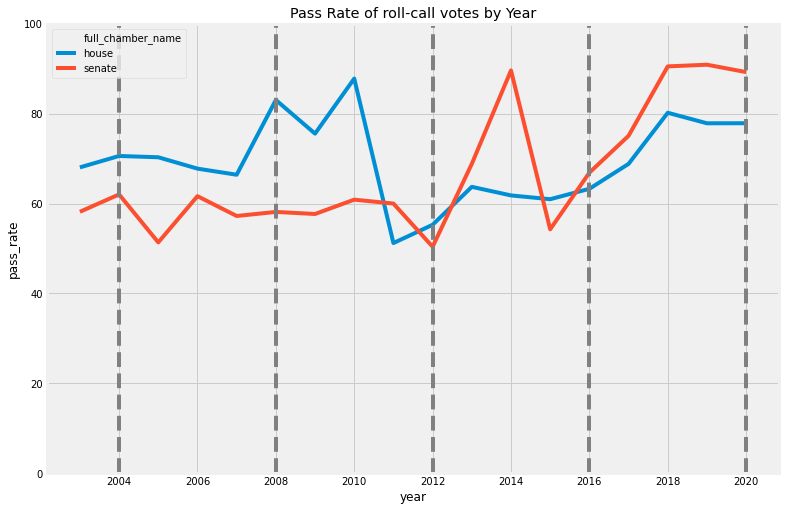

In [18]:
fig=plt.figure()
fig.set_size_inches(11.7, 8.27)

ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

sns.lineplot(x="year", y="pass_rate", hue=tmp["full_chamber_name"], data=tmp)
plt.ylim((0,100))
for i in range(2004, 2024, 4):
    plt.axvline(x=i,c="gray", linestyle="--")
plt.title("Pass Rate of roll-call votes by Year")
plt.show()

It appears that the pass rate for roll-call votes has increased since 2003. We note that pass rate of roll-call votes may not completely reflect Congressional productivity. For example, [2014 was noted as a Congress which sent the least bills to the President in 20 years](https://thehill.com/blogs/floor-action/senate/227365-historically-unproductive-congress-ends). Some articles suggest that the pass rate or even number of [bills may not be correlated with productivty, because Congress may not be passing substantive bills](https://www.pewresearch.org/fact-tank/2019/01/25/a-productivity-scorecard-for-115th-congress/).

# Discussion

## Limitations & Ideas to address them

This section discusses potential ideas to extend the findings and analysis contained in this report.
### Gather more data to identify trends in polarization more strongly
The biggest limitation of this analysis is the limited amount of data were able to scrape. The [GitHub Congress project wiki contains zip files with Congressional bills dating back to 1973](https://github.com/unitedstates/congress/wiki), however due to limited computing power and internet bandwith we were not able to analyze this complete dataset in the course of the report.

Getting more data for this analysis would provide greater clarity for some of the findings from this notebook which are limited by the 17 years of analysis presented here.

### Analysis of polarization by bill topics
The [Congress project scraper can also collect bill data](https://github.com/unitedstates/congress/wiki/bills). Tying together measurements of polarization with bill topics may provide greater clarity into: 

  1. How polarization of bill topics has evolved over time
  2. What topics to target to make Congress the most effective

### A closer look at the impact of the earmark bill on polarization
We saw a significant decrease in the pass rate following 2011, the year that the bill which banned earmarks was passed by Congress. Earmarks could be considered ways for Congressmemebers to add requests for funding for projects of interest on unrelated bills, however they may have also helped provide some additional political capital for trade on particularly contentious bills. It would be interesting to find a study which estimates the impact that the ban on earmarks had on polarization in Congress.

## Implications

### Congress is *potentially* getting more polarized
The data suggests that there is potential increase in roll-call votes in Congress as according to the differene in votes metric. However, the data also shows high variability in the metric, making it difficult to determine the long term trend of the polarization.

### Being more polarized does not necessarily mean that Congress should be less effective
Productivity of Congress, as discussed further in the Conclusion, has been a constant focus of news articles. However, the relationship between productivity and polarization is not completely clear. The pass rate of roll-call votes recovered after 2011. However, if we look at the number of roll-call votes which have passed more recently, there did appear to be a slight downtrend

# Conclusion
In this report, we observed the difference in votes of support for bills by party from 2003-2020 as a measure of the polarization of Congress. We found that the mean difference in votes over the last 17 years could suggest a modest increase in the polarization of the Senate, and a more substantial increase in polarization for the House -- however, we would caution against drawing strong conclusions from the limited dataset we were able to gather here. Other [research supports the idea that Congress has increased in polarization over the last decade and a half](https://www.pewresearch.org/fact-tank/2014/06/12/polarized-politics-in-congress-began-in-the-1970s-and-has-been-getting-worse-ever-since/).

Moreover, during our exploration of the *difference* of the difference in votes between consecutive years, we found that the variation in the last 17 years has not changed dramatically (besides the outlier year of 2011 in the House), suggesting that the rate of polarization may not be substantially changing over the time period we examined.

## Appendix: How to obtain the starting data

### Manual steps to get the dataset
*These are the same instructions contained in the [README file](./README.md).*

The dataset is large, a copy is kept in a zip folder [data/data.zip](data/data.zip) for ease of reproducability.

To reproduce the steps to get the original data:
  1. Navigate to a folder where you want to clone the github repo.
  2. Run: git clone "https://github.com/unitedstates/congress.git"
  3. Follow the [setting up instructions](https://github.com/unitedstates/congress.git).
  4. Copy [code/scripts/get_votes.ps1] to the root folder of the congress directory on your computer.
  5. Run get_votes.ps1
  
**Note:** this may take anywhere bewteeen 5 hours to a few days depending on your internet connection.

### Data quality validation
#### Results of the data quality validation
For the dataset in this analysis the years between 2003-2020 differed by fewer than 2% from the vote counts recorded on the website shared above in "Steps to validate data quality". 

#### Steps to validate data quality
Since the dataset is large and the process to get it is long-running we neded a manner to validate the data quality prior to running our analalysis. We performed the following steps to verify data quality from the long-running download task in "Manual steps to get the dataset":

   1. Navigate to https://www.govtrack.us/congress/votes
   2. Find the "Filter Votes" box and select the year whose vote count you want to verify, as shown below:
   <br/>*Screenshot of the "Filter Votes" box December 6, 2020*
   
   ![Screenshot of the "Filter Votes" box December 6, 2020](pictures/data-verification/filter-votes.png "Filter Votes button")
   
   <br/>
   
   *Screenshot of the "Filter Votes" year selection December 6, 2020*
   
   ![Screenshot of the expanded "Filter Votes" selection box December 6, 2020](pictures/data-verification/filter-votes-expanded-select.png "Filter Votes year selection")
   3. Wait for the page to load, and then take note of the count of votes displayed on the screen, as highlighted, circled and arrowed in the below screenshot.
   <br/>*Screenshot of the vote count (1,035) December 6, 2020*
   ![Screenshot of the vote count December 6, 2020](pictures/data-verification/vote-count.png "Vote count on the screen")
   4. Compare the vote count (e.g., 1,035 in the screenshot above) with the total votes in your downloaded dataset.
   
For convenience, here are the results of carrying out these steps for the years 2003-2020 as of December 6th, 2020 (i.e.: 2020 is incomplete):

*Table: the count of votes in Congress by year according to https://www.govtrack.us/congress/votes*
<br />

| Year | Vote count |
| ---- | ---- |
| 2020 | 488 |
| 2019 | 1129 |
| 2018 | 774 |
| 2017 | 1035 |
| 2016 | 784 |
| 2015 | 1043 |
| 2014 | 929 |
| 2013 | 932 |
| 2012 | 909 |
| 2011 | 1183 |
| 2010 | 963 |
| 2009 | 1388 |
| 2008 | 905 |
| 2007 | 1628 |
| 2006 | 822 |
| 2005 | 1037 |
| 2004 | 760 |
| 2003 | 1136 |
